# Doublet Detection

### Setup and Load Data

DoubletDetection expects counts to be in the cellranger output format either as h5 file (filtered_feature_bc_matrix.h5) or matrix directory (directory containing `barcodes.tsv`, `genes.tsv` and `matrix.mtx` or `barcodes.tsv.gz`, `features.tsv.gz` and `matrix.mtx.gz`)

If you don’t have your data in either of these formats, you can run DoubletDetection manually in python and load the data in using a method of your choosing.

In [3]:
import os
import numpy as np
import doubletdetection
import tarfile
import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import sys
import pandas as pd
import scanpy as sc
import scipy
import scipy.io

import anndata

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

sample_name = r'sc85_1g'

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.10.3 anndata==0.11.0 umap==0.5.7 numpy==1.26.4 scipy==1.14.1 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.8 louvain==0.8.2 pynndescent==0.5.13
scanpy==1.10.3 anndata==0.11.0 umap==0.5.7 numpy==1.26.4 scipy==1.14.1 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.8 louvain==0.8.2 pynndescent==0.5.13


In [4]:
adata = anndata.read_h5ad("pseudo_doublets_sc85_1g.h5ad")                # write a cache file for faster subsequent reading

# adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
print('Data matrix is sparse:', scipy.sparse.issparse(adata.X))
print()

print('Number of cells =', f"{adata.n_obs:,.0f}")
print('Number of genes =', f"{adata.n_vars:,.0f}")
print('Number of counts =', f"{adata.X.sum():,.0f}")
print('Mean counts per cell =', f"{adata.X.sum()/adata.n_obs:,.0f}")
adata

print()
print(adata.obs)

Data matrix is sparse: True

Number of cells = 14,480
Number of genes = 25,051
Number of counts = 6,061,941
Mean counts per cell = 419

                          doublet
rDbl.1                        1.0
rDbl.2                        1.0
rDbl.3                        1.0
rDbl.4                        1.0
rDbl.5                        1.0
...                           ...
TTTGTTGGTTAAGTGT_sc85_1g      0.0
TTTGTTGGTTACGCGG_sc85_1g      0.0
TTTGTTGGTTAGGATT_sc85_1g      0.0
TTTGTTGGTTGCCTCA_sc85_1g      0.0
TTTGTTGGTTGGCGTG_sc85_1g      0.0

[14480 rows x 1 columns]


In [5]:
n_cells = adata.n_obs
n_genes = adata.n_vars
n_counts = adata.X.sum()    
counts_per_cell = round(n_counts / n_cells)

df_metrics = pd.DataFrame({"Number of cells": [n_cells],
                          "Number of genes": [n_genes], 
                          "Number of counts": [n_counts], 
                          "Mean counts per cell": [counts_per_cell]}, 
                          index=[sample_name])


df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].map('{:,.0f}'.format)
df_metrics.index = [sample_name]
df_metrics

C:\Users\leeh1\AppData\Local\Temp\ipykernel_15324\1653201150.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sc85_1g    25,051
Name: Number of genes, dtype: object' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].map('{:,.0f}'.format)
C:\Users\leeh1\AppData\Local\Temp\ipykernel_15324\1653201150.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sc85_1g    6,061,941
Name: Number of counts, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].map('{:,.0f}'.format)
C:\Users\leeh1\AppData\Local\Temp\ipykernel_15324\1653201150.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sc85_1g 

,Number of cells,Number of genes,Number of counts,Mean counts per cell
sc85_1g,14480,"25,051","6,061,941",419


### Detect doublets
Remove "empty" genes before doublet detection.

In [6]:
sc.pp.filter_genes(adata, min_cells=1)
df_metrics['Filter genes:'] = ' '
df_metrics['Number of genes removed'] = n_genes - adata.n_vars

filtered out 490 genes that are detected in less than 1 cells


In [7]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:01)


In [8]:
# IMPORTANT: changed `np.log(scaled_aug_counts.A + 0.1)` => `np.log(scaled_aug_counts.toarray() + 0.1)` in DoubletDetection source code
svd_solver='arpack'

clf = doubletdetection.BoostClassifier(
    n_iters=10,
    clustering_algorithm="leiden",
    standard_scaling=True,
    pseudocount=0.1,
    n_jobs=-1,
)
doublets = clf.fit(adata.X).predict(p_thresh=1e-16, voter_thresh=0.5)
doublet_score = clf.doublet_score()

C:\Users\leeh1\McKinnonRosatiLab\jl\lib\site-packages\doubletdetection\doubletdetection.py:116: UserWarning: Leiden clustering is experimental and results have not been validated.
  warnings.warn("Leiden clustering is experimental and results have not been validated.")


  0%|          | 0/10 [00:00<?, ?it/s]

computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.`
    with n_comps=30
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:27)
running Leiden clustering


C:\Users\leeh1\McKinnonRosatiLab\jl\lib\site-packages\doubletdetection\doubletdetection.py:350: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  clus(


    finished: found 67 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:01)
computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.`
    with n_comps=30
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 67 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:01)
computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.`
    with n_comps=30
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finis

### Results
Doublet vs singlet ratios

In [9]:
adata.obs["doublet"] = doublets
adata.obs["dblDetect_score"] = doublet_score
adata.obs["dblDetect_class"] = ['doublet' if x == 1.0 else 'singlet' for x in doublets]

adata.obs

,doublet,dblDetect_score,dblDetect_class
rDbl.1,1.0,1.195961e+02,doublet
rDbl.2,0.0,1.113629e+01,singlet
rDbl.3,1.0,9.869107e+01,doublet
rDbl.4,0.0,2.006792e+01,singlet
rDbl.5,1.0,1.308539e+02,doublet
...,...,...,...
TTTGTTGGTTAAGTGT_sc85_1g,0.0,5.069180e-03,singlet
TTTGTTGGTTACGCGG_sc85_1g,0.0,2.315556e-42,singlet
TTTGTTGGTTAGGATT_sc85_1g,0.0,2.424384e-11,singlet
TTTGTTGGTTGCCTCA_sc85_1g,0.0,4.962641e+01,singlet


In [10]:
adata.obs["doublet"] = doublets
adata.obs["dblDetect_score"] = doublet_score
adata.obs["dblDetect_class"] = ['doublet' if x == 1.0 else 'singlet' for x in doublets]

adata.obs

,doublet,dblDetect_score,dblDetect_class
rDbl.1,1.0,1.195961e+02,doublet
rDbl.2,0.0,1.113629e+01,singlet
rDbl.3,1.0,9.869107e+01,doublet
rDbl.4,0.0,2.006792e+01,singlet
rDbl.5,1.0,1.308539e+02,doublet
...,...,...,...
TTTGTTGGTTAAGTGT_sc85_1g,0.0,5.069180e-03,singlet
TTTGTTGGTTACGCGG_sc85_1g,0.0,2.315556e-42,singlet
TTTGTTGGTTAGGATT_sc85_1g,0.0,2.424384e-11,singlet
TTTGTTGGTTGCCTCA_sc85_1g,0.0,4.962641e+01,singlet


In [11]:
doublet_percentage = sum(doublets)/adata.n_obs*100
print('Doublet percentage = %4.1f' %(doublet_percentage))
df_metrics['Doublet removal:'] = ' '
df_metrics['Doublet percentage'] =  doublet_percentage
# print(adata.obs)
adata.obs.dblDetect_class.value_counts() 

Doublet percentage =  3.7


dblDetect_class
singlet    13938
doublet      542
Name: count, dtype: int64

In [12]:
num_before = adata.n_obs
singlets = adata.obs["dblDetect_class"] == 'singlet'
num_after = adata[singlets].n_obs
n_genes = adata[singlets].n_vars
n_counts = adata[singlets].X.sum()    
counts_per_cell = round(n_counts / n_cells)

print('Number of cells before doublet removal =', num_before)
print('Number of cells after doublet removal =', num_after)
print('Number of cells removed =', num_before - num_after)
removed_percentage = (num_before - num_after)/num_before*100
print('Percentage of cells removed = %4.1f' %(removed_percentage))
n_counts = adata.X.sum()  
print('Number of counts =', f"{n_counts:,.0f}")
print('Mean counts per cell =', f"{counts_per_cell:,.0f}")

df_metrics['Number of cells removed'] =  num_before - num_after
df_metrics['After doublet removal:'] = ' '
df_metrics['Number of cells -db'] = num_after
df_metrics['Number of genes -db'] = n_genes
df_metrics['Number of counts -db'] = n_counts
df_metrics['Mean counts per cell -db'] = counts_per_cell

Number of cells before doublet removal = 14480
Number of cells after doublet removal = 13938
Number of cells removed = 542
Percentage of cells removed =  3.7
Number of counts = 4,329,385
Mean counts per cell = 286


### Visuals
Visualizing the data after doublet removal through violin plots, UMAPs, and scatterplots

In [13]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:08)


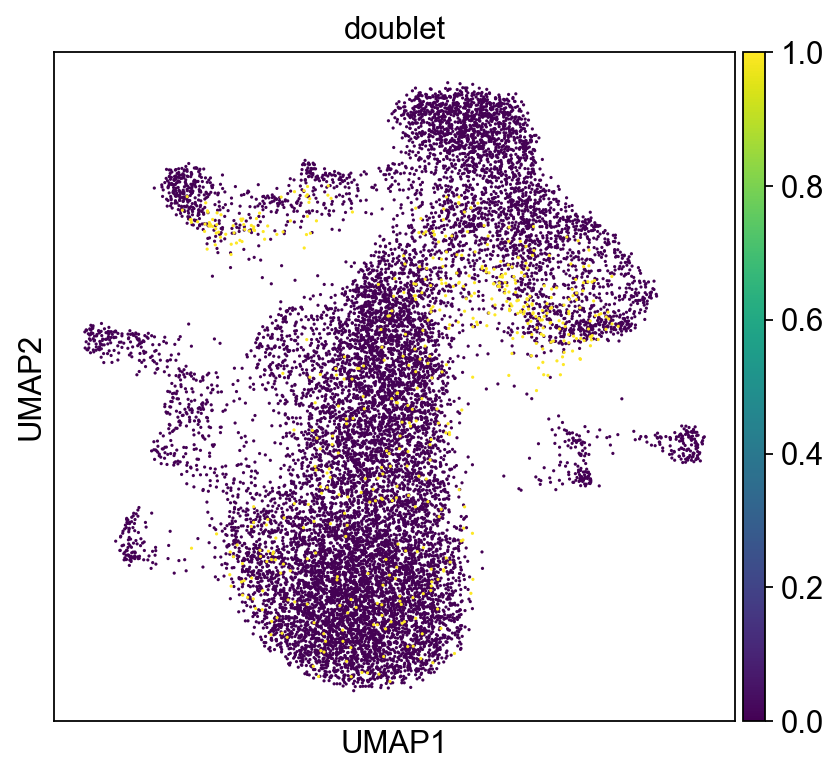

In [14]:
rcParams['figure.figsize'] = 6, 5.5
sc.pl.umap(adata, color='doublet', legend_loc='best')

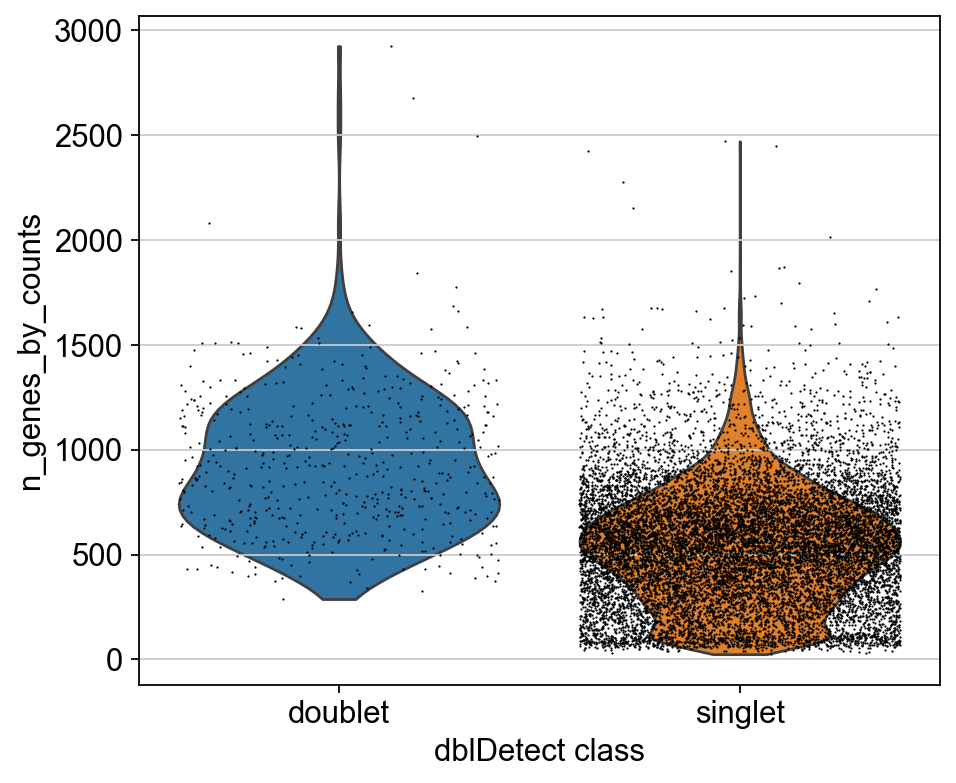

In [15]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, 'n_genes_by_counts',jitter=0.4, groupby = 'dblDetect_class')

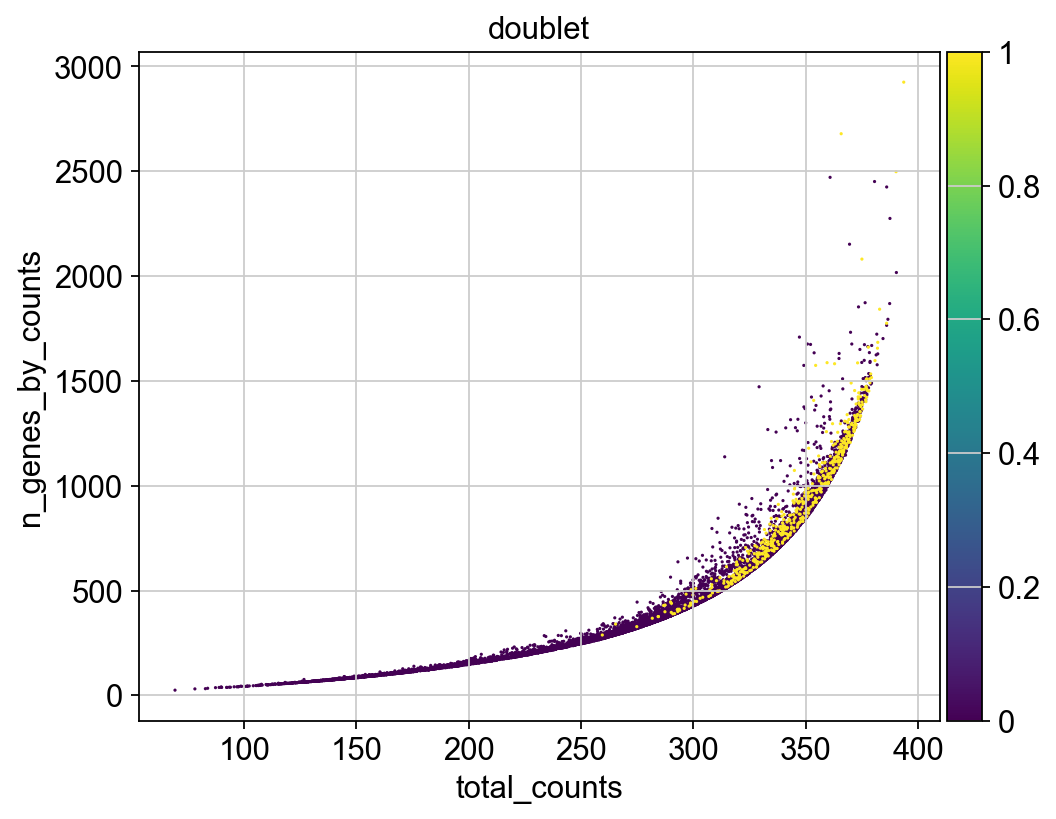

In [16]:
sc.pl.scatter(adata, 'total_counts', 'n_genes_by_counts', color='doublet')

### Exporting Doublets to a `.txt` file
Printing out doublet subsets for future comparisons

In [17]:
print(adata.obs[adata.obs['dblDetect_class'] == 'doublet'])
adata_dbl = adata[adata.obs['dblDetect_class'] == 'doublet'].copy()

                          doublet  dblDetect_score dblDetect_class  \
rDbl.1                        1.0       119.596052         doublet   
rDbl.3                        1.0        98.691065         doublet   
rDbl.5                        1.0       130.853922         doublet   
rDbl.6                        1.0        98.691065         doublet   
rDbl.9                        1.0        56.726260         doublet   
...                           ...              ...             ...   
TTGTGTGCATTCCTGT_sc85_1g      1.0        61.354721         doublet   
TTGTTGTTCATTGCAA_sc85_1g      1.0       268.643214         doublet   
TTTAAGGTCGAGCTAT_sc85_1g      1.0        36.592644         doublet   
TTTGTGAAGGACAATG_sc85_1g      1.0        36.592644         doublet   
TTTGTGTTCCCTCAAC_sc85_1g      1.0        36.592644         doublet   

                          n_genes_by_counts  total_counts  
rDbl.1                                  834    342.692595  
rDbl.3                                 

In [18]:
print(adata_dbl.obs_names)

Index(['rDbl.1', 'rDbl.3', 'rDbl.5', 'rDbl.6', 'rDbl.9', 'rDbl.13', 'rDbl.14',
       'rDbl.35', 'rDbl.36', 'rDbl.39',
       ...
       'TTATGCGCAAGGTGCA_sc85_1g', 'TTCATCCCACCTGTAA_sc85_1g',
       'TTGCCCGTCTAGCGTG_sc85_1g', 'TTGCGAGTCGTTAAGC_sc85_1g',
       'TTGCTTAGTCCGTAGG_sc85_1g', 'TTGTGTGCATTCCTGT_sc85_1g',
       'TTGTTGTTCATTGCAA_sc85_1g', 'TTTAAGGTCGAGCTAT_sc85_1g',
       'TTTGTGAAGGACAATG_sc85_1g', 'TTTGTGTTCCCTCAAC_sc85_1g'],
      dtype='object', length=542)


In [19]:
with open("./sc85_1g_IDs/DoubletDetection_sc85_1g_pseudo_ids.txt", "w") as txt_file:
    for cell in adata_dbl.obs_names:
        txt_file.write(cell + "\n")